<a href="https://colab.research.google.com/github/maheshbali/microsoft/blob/main/The_Nirvana_App_For_Breath_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install heartpy

     |████████████████████████████████| 1.0 MB 7.4 MB/s 


In [2]:
import warnings

import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.signal import welch, periodogram

import heartpy as hp

__all__ = ['calc_rr',
           'update_rr',
           'calc_rr_segment',
           'clean_rr_intervals',
           'calc_ts_measures',
           'calc_fd_measures',
           'calc_breathing']

In [3]:
def calc_rr(peaklist, sample_rate, working_data={}):
    '''calculates peak-peak intervals

    Function that calculates the peak-peak data required for
    further analysis. Stores results in the working_data{} dict.

    Parameters
    ----------
    peaklist : 1d list or array
        list or array containing detected peak positions

    sample_rate : int or float
        the sample rate with which the heart rate signal is collected

    working_data : dict
        dictionary object that contains all heartpy's working data (temp) objects.
        will be created if not passed to function

    Returns
    -------
    working_data : dict
        working_data dictionary object containing all of heartpy's temp objects

    Examples
    --------
    Let's assume we detected peaks at these positions in the signal:

    >>> peaklist = [200, 280, 405, 501, 615]

    It is then easy to call calc_rr to compute what we need:

    >>> wd = calc_rr(peaklist, sample_rate = 100.0)
    >>> wd['RR_list']
    array([ 800., 1250.,  960., 1140.])
    >>> wd['RR_diff']
    array([450., 290., 180.])
    >>> wd['RR_sqdiff']
    array([202500.,  84100.,  32400.])

    Note that the list of peak-peak intervals is of length len(peaks) - 1
    the length of the differences is of length len(peaks) - 2
    '''
    peaklist = np.array(peaklist) #cast numpy array to be sure or correct array type

    #delete first peak if within first 150ms (signal might start mid-beat after peak)
    if len(peaklist) > 0:
        if peaklist[0] <= ((sample_rate / 1000.0) * 150):
            peaklist = np.delete(peaklist, 0)
            working_data['ybeat'] = np.delete(working_data['ybeat'], 0)
    working_data['peaklist'] = peaklist # Make sure, peaklist is always an np.array

    rr_list = (np.diff(peaklist) / sample_rate) * 1000.0
    rr_indices = [(peaklist[i], peaklist[i+1]) for i in range(len(peaklist) - 1)]
    rr_diff = np.abs(np.diff(rr_list))
    rr_sqdiff = np.power(rr_diff, 2)
    working_data['RR_list'] = rr_list
    working_data['RR_indices'] = rr_indices
    working_data['RR_diff'] = rr_diff
    working_data['RR_sqdiff'] = rr_sqdiff
    return working_data

In [4]:
def update_rr(working_data={}):
    '''updates differences between adjacent peak-peak distances

    Function that updates RR differences and RR squared differences
    based on corrected RR list

    Parameters
    ----------
    working_data : dict
        dictionary object that contains all heartpy's working data (temp) objects
        will be created if not passed to function

    Returns
    -------
    out : dict
        working_data dictionary object containing all of heartpy's temp objects

    Examples
    --------
    Let's assume we detected peaks at these positions in the signal:

    >>> peaklist = [200, 280, 405, 410, 501, 615]

    And we subsequently ran further analysis:

    >>> wd = calc_rr(peaklist, sample_rate = 100.0)

    The peak at position 410 is likely an incorrect detection and
    will be marked as such by other heartpy functions. This is indicated
    by an array 'binary_peaklist' in working_data. Binary peaklist is of
    the same length as peaklist, and is formatted as a mask:

    For now let's set it manually, normally this is done by the check_peaks()
    function from HeartPy's peakdetection module.

    >>> wd['binary_peaklist'] = [1, 1, 1, 0, 1, 1]

    Rejected peaks are marked with a zero and accepted with a 1.

    By now running update_rr(), heartpy will update all associated measures
    and will only compute peak-peak intervals between two accepted peaks.

    >>> wd = update_rr(wd)

    This will have generated a corrected RR_list object in the dictionary:

    >>> wd['RR_list_cor']
    array([ 800., 1250., 1140.])

    As well as updated the lists RR_diff (differences between adjacent peak-peak intervals) and
    RR_sqdiff (squared differences between adjacent peak-peak intervals).
    '''
    rr_source = working_data['RR_list']
    b_peaklist = working_data['binary_peaklist']
    rr_list = np.array([rr_source[i] for i in range(len(rr_source)) if b_peaklist[i] + b_peaklist[i+1] == 2])
    rr_mask = np.array([0 if (b_peaklist[i] + b_peaklist[i+1] == 2) else 1 for i in range(len(rr_source))])
    rr_masked = np.ma.array(rr_source, mask=rr_mask)
    rr_diff = np.abs(np.diff(rr_masked))
    rr_diff = rr_diff[~rr_diff.mask]
    rr_sqdiff = np.power(rr_diff, 2)

    working_data['RR_masklist'] = rr_mask
    working_data['RR_list_cor'] = rr_list
    working_data['RR_diff'] = rr_diff
    working_data['RR_sqdiff'] = rr_sqdiff

    return working_data

In [5]:
def calc_breathing(rrlist, method='welch', filter_breathing=True,
                   bw_cutoff=[0.1, 0.4], measures={}, working_data={}):
    '''estimates breathing rate

    Function that estimates breathing rate from heart rate signal.
    Upsamples the list of detected rr_intervals by interpolation then
    tries to extract breathing peaks in the signal.

    Parameters
    ----------
    rr_list : 1d list or array
        list or array containing peak-peak intervals

    method : str
        method to use to get the spectrogram, must be 'fft' or 'welch'
        default : fft

    filter_breathing : bool
        whether to filter the breathing signal derived from the peak-peak intervals
        default : True

    bw_cutoff : list or tuple
        breathing frequency range expected
        default : [0.1, 0.4], meaning between 6 and 24 breaths per minute

    measures : dict
        dictionary object used by heartpy to store computed measures. Will be created
        if not passed to function.

    working_data : dict
        dictionary object that contains all heartpy's working data (temp) objects.
        will be created if not passed to function

    Returns
    -------
    measures : dict
        dictionary object used by heartpy to store computed measures.

    Examples
    --------
    Normally this function is called during the process pipeline of HeartPy. It can
    of course also be used separately.

    Let's load an example and get a list of peak-peak intervals

    >>> import heartpy as hp
    >>> data, _ = hp.load_exampledata(0)
    >>> wd, m = hp.process(data, 100.0)

    Breathing is then computed with the function

    >>> m, wd = calc_breathing(wd['RR_list_cor'], measures = m, working_data = wd)
    >>> round(m['breathingrate'], 3)
    0.171

    There we have it, .17Hz, or about one breathing cycle in 6.25 seconds.
    '''

    #resample RR-list to 1000Hz
    x = np.linspace(0, len(rrlist), len(rrlist))
    x_new = np.linspace(0, len(rrlist), np.sum(rrlist, dtype=np.int32))
    interp = UnivariateSpline(x, rrlist, k=3)
    breathing = interp(x_new)

    if filter_breathing:
        breathing = hp.filtering.filter_signal(breathing, cutoff=bw_cutoff,
                                               sample_rate = 1000.0, filtertype='bandpass')

    if method.lower() == 'fft':
        datalen = len(breathing)
        frq = np.fft.fftfreq(datalen, d=((1/1000.0)))
        frq = frq[range(int(datalen/2))]
        Y = np.fft.fft(breathing)/datalen
        Y = Y[range(int(datalen/2))]
        psd = np.power(np.abs(Y), 2)
    elif method.lower() == 'welch':
        if len(breathing) < 30000:
            frq, psd = welch(breathing, fs=1000, nperseg=len(breathing))
        else:
            frq, psd = welch(breathing, fs=1000, nperseg=np.clip(len(breathing) // 10,
                                                                 a_min=30000, a_max=None))
    elif method.lower() == 'periodogram':
        frq, psd = periodogram(breathing, fs=1000.0, nfft=30000)

    else:
        raise ValueError('Breathing rate extraction method not understood! Must be \'welch\' or \'fft\'!')

    #find max
    measures['breathingrate'] = frq[np.argmax(psd)]
    working_data['breathing_signal'] = breathing
    working_data['breathing_psd'] = psd
    working_data['breathing_frq'] = frq

    return measures, working_data

In [6]:
# Let's load an example and get a list of peak-peak intervals

import heartpy as hp
data, _ = hp.load_exampledata(0)
wd, m = hp.process(data, 100.0)

#Breathing is then computed with the function
m, wd = calc_breathing(wd['RR_list_cor'], measures = m, working_data = wd)
round(m['breathingrate'], 3)

0.171

In [7]:
#Therefore it is .17Hz, or about one breathing cycle in 6.25 seconds.

In [8]:
'''
Functions that help visualize results
'''

import os

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

#from . import config

__all__ = ['plotter',
           'segment_plotter',
           'plot_poincare',
           'plot_breathing']

In [9]:
def plot_breathing(working_data, measures, show=True, figsize=None): # pragma: no cover
    '''plots extracted breathing signal and spectrogram

    Function that plots the breathing signal extracted from RR-intervals alongside
    its computed spectrogram representation.

    Parameters
    ----------
    working_data : dict
        dictionary object that contains all heartpy's working data (temp) objects.
        will be created if not passed to function

    measures : dict
        dictionary object used by heartpy to store computed measures. Will be created
        if not passed to function

    show : bool
        whether to show the plot right away, or return a matplotlib object for
        further manipulation

    figsize: tuple
        Set dimensions of image in inches like in matplotlib. figsize=(x, y)
        default: None => (6.4, 4.8)

    Returns
    -------
    out : matplotlib plot object
        only returned if show == False.

    Examples
    --------
    This function has no examples. See documentation of heartpy for more info.
    '''

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    ax1.plot(working_data['breathing_signal'], label='breathing signal')
    ax1.set_xlabel('ms')
    ax1.set_title('breathing signal extracted from RR-intervals')

    ax2.plot(working_data['breathing_frq'], working_data['breathing_psd'], label='spectrogram')
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Hz')
    ax2.set_title('spectrogram extracted from breathing rate signal')

    ax2.legend()
    plt.tight_layout()

    if show:
        fig.show()
    else:
        return fig

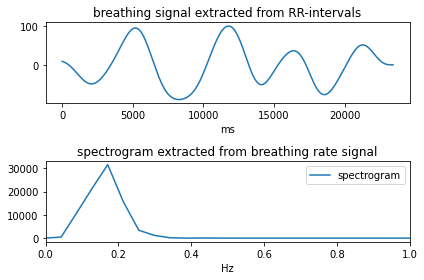

In [10]:
plot_breathing(wd, m, show=True, figsize=None)